# Ensemble Growth Optimal (EGO) Portfolio Example

The **Kelly Criterion** is theoretically optimal for long-term wealth but is notoriously unstable with limited data. If the input distribution is slightly off, Kelly suggests wild leverage.

This example implements **Ensemble Learning** to stabilize the Kelly criterion, based on *The Kelly Growth Optimal Portfolio with Ensemble Learning* by **Weiwei Shen, Bin Wang, Jian Pu, and Jun Wang (2019)**.

### The Math: Bagging & Random Subspaces
Instead of relying on one noisy estimate, we use a two-layer ensemble to smooth out errors:

1.  **Outer Loop (Bagging):** Generate $n_1$ synthetic histories via parametric bootstrapping to simulate alternative market realities.
2.  **Inner Loop (Random Subspace):** For each history, solve optimal weights for $n_3$ random subsets of assets (size $n_4$).

The final weight is the average of all sub-portfolios:
$$
\hat{\omega}_{EGO} = \frac{1}{n_1} \sum_{h=1}^{n_1} \left( \frac{1}{n_3} \sum_{j=1}^{n_3} \hat{\omega}_{h,j} \right)
$$

#### Hyperparameters
* **$n_1$ (Resamples):** Number of synthetic histories (Bagging).
* **$n_2$ (Length):** Length of synthetic history (should be $3\tau - 5\tau$).
* **$n_3$ (Subsets):** Number of random asset "teams".
* **$n_4$ (Subset Size):** The regularizer. Restricting the solver to $\approx N^{0.7}$ assets prevents overfitting to spurious correlations.

Running 50 simulations for 20 assets...
EGO Parameters: Resamples=50, Length=150, Subsets=50, Subset Size=8
Simulation 0/50...
Simulation 10/50...
Simulation 20/50...
Simulation 30/50...
Simulation 40/50...


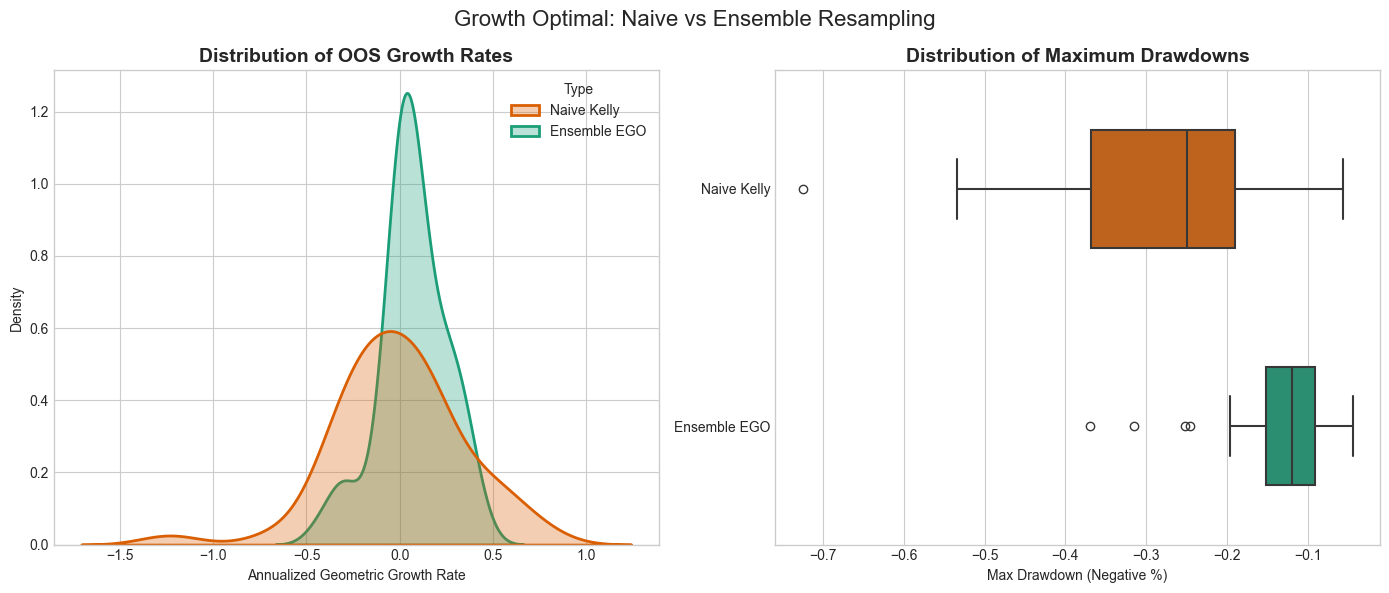

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from PortfolioResampling.EnsembleGrowthOptimal import naive_growth_optimal, ensemble_growth_optimal_portfolio
from HelperFunctions.Functions import max_drawdown, geometric_growth_rate

# simulation setup
np.random.seed(42)

# Simulation Parameters
N_SIMULATIONS = 50    
T_LOOKBACK = 30      # 30 weeks (~7 month) in-sample training (Data Poor Regime)
T_FORWARD = 52       # 1 Year OOS
N_ASSETS = 20        # Universe size

# EGO Hyperparameters (Guidelines from Shen et al. 2019)
N1_RESAMPLES = 50    # Outer loop: Synthetic histories
N2_LENGTH = 150      # Synthetic history length (5 * T_LOOKBACK)
N3_SUBSETS = 50      # Inner loop: Random teams
N4_SIZE = int(N_ASSETS**0.7)  # Subset size (~8 assets)

# Generate Random True Market Parameters
mu_true = np.abs(np.random.randn(N_ASSETS) * 0.0015 + 0.001) 
sigma_vec = np.abs(np.random.randn(N_ASSETS) * 0.02 + 0.04)

# Random Correlation Structure
rnd = np.random.randn(N_ASSETS, N_ASSETS)
corr_base = rnd @ rnd.T
D_inv = np.diag(1.0 / np.sqrt(np.diag(corr_base)))
corr = D_inv @ corr_base @ D_inv
Sigma_true = np.outer(sigma_vec, sigma_vec) * corr

results = []

print(f"Running {N_SIMULATIONS} simulations for {N_ASSETS} assets...")
print(f"EGO Parameters: Resamples={N1_RESAMPLES}, Length={N2_LENGTH}, Subsets={N3_SUBSETS}, Subset Size={N4_SIZE}")

for i in range(N_SIMULATIONS):
    if i % 10 == 0: print(f"Simulation {i}/{N_SIMULATIONS}...")
    
    # 1. Generate Historical Data (In-Sample Training)
    returns_hist = np.random.multivariate_normal(mu_true, Sigma_true, T_LOOKBACK)
    
    # 2. Solve Portfolios
    # A) Naive Kelly: Solved on the raw full dataset
    w_naive = naive_growth_optimal(returns_hist)
    
    # B) Ensemble EGO: Solved via Resampling & Aggregation
    w_ensemble = ensemble_growth_optimal_portfolio(
        returns_hist, 
        n1=N1_RESAMPLES, 
        n2=N2_LENGTH, 
        n3=N3_SUBSETS, 
        n4=N4_SIZE
    )
        
    # 3. Test Out-of-Sample
    returns_oos = np.random.multivariate_normal(mu_true, Sigma_true, T_FORWARD)
    
    r_naive = returns_oos @ w_naive
    r_ensemble = returns_oos @ w_ensemble
    
    results.append({
        'Type': 'Naive Kelly', 
        'GrowthRate': geometric_growth_rate(r_naive), 
        'MaxDrawdown': max_drawdown(r_naive)
    })
    results.append({
        'Type': 'Ensemble EGO', 
        'GrowthRate': geometric_growth_rate(r_ensemble), 
        'MaxDrawdown': max_drawdown(r_ensemble)
    })

df_res = pd.DataFrame(results)

plt.style.use('seaborn-v0_8-whitegrid')
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

palette = {'Naive Kelly': "#d95f02", 'Ensemble EGO': "#1b9e77"}

# Plot 1: Geometric Growth Rate (The Kelly Objective)
sns.kdeplot(data=df_res, x='GrowthRate', hue='Type', fill=True, 
            alpha=0.3, linewidth=2, palette=palette, ax=axes[0])
axes[0].set_title('Distribution of OOS Growth Rates', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Annualized Geometric Growth Rate')
axes[0].set_ylabel('Density')

# Plot 2: Max Drawdown (The Risks)
sns.boxplot(data=df_res, x='MaxDrawdown', y='Type', hue='Type', legend=False, orient='h', 
            palette=palette, width=0.5, linewidth=1.5, ax=axes[1])
axes[1].set_title('Distribution of Maximum Drawdowns', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Max Drawdown (Negative %)')
axes[1].set_ylabel('')

plt.suptitle(f'Growth Optimal: Naive vs Ensemble Resampling', fontsize=16)
plt.tight_layout()
plt.show()